In [1]:
import os
os.environ["tf_cpp_min_log_level"] = "2"

import pandas as pd
import numpy as np
import cv2

import tensorflow_io as tfio
import tensorflow_addons as tfa

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Concatenate
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_probability as tfp


import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import random

physical_devices = tf.config.list_physical_devices("GPU")
physical_devices2 = tf.config.list_physical_devices("CPU")

tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices[0], physical_devices2

(PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')])

## <span style="color:blue">Data preparation</span>

### <span style="color:darkblue">Read and investigate the dataset</span>

In [2]:
#Define file path
path_root = "D:\\Datasets\\Road_Segments\\"

path_train_images = path_root + "Train\\Img\\"
path_train_labels = path_root + "Train\\Mask\\"
path_test_images = path_root + "Test\\Img\\"

In [3]:
#Define the image-reading function
def Read_Imgs(path_img, path_label=None):
    x = []
    y = []
    
    #Read the images
    for _,_,img_files in os.walk(path_img):
        for img_file in tqdm(img_files):
            if img_file.split(".")[-1] == "jpg":  #only get the image files
                path_image = path_img + img_file
                img = plt.imread(path_image)
                
                x.append(img)
                
                #Read the corresponding label for training set
                if path_label!=None:
                    for _,_,label_files in os.walk(path_label):
                        for label_file in label_files:
                            #Check if the label file name is the same to the image file name
                            if label_file.split(".")[0] == img_file.split(".")[0]:
                                path_mask = path_label + label_file
                                mask = cv2.imread(path_mask)
                                
                                y.append(mask)
    if path_label!=None:
        return np.array(x), np.array(y)
    else:
        return np.array(x)

In [4]:
#Read the images, masks and check their shapes
x_train, y_train = Read_Imgs(path_img=path_train_images, path_label=path_train_labels)
x_test = Read_Imgs(path_img=path_test_images)

x_train.shape, y_train.shape, x_test.shape

100%|██████████| 38/38 [00:01<00:00, 22.31it/s]
<ipython-input-3-6d084452e292>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(x)


((10, 4800, 3200, 3), (10, 4800, 3200, 3), (8,))

In [5]:
#The test images are not in an uniform shape
for i in range(x_test.shape[0]):
    print(x_test[i].shape)

(5710, 5749, 3)
(2079, 5749, 3)
(4800, 3200, 3)
(4800, 3200, 3)
(4800, 3200, 3)
(4800, 3200, 3)
(4800, 3200, 3)
(4800, 3200, 3)


(-0.5, 5748.5, 5709.5, -0.5)

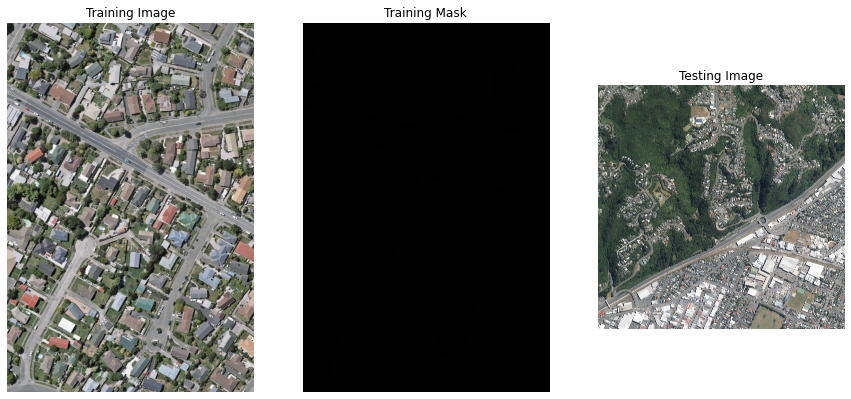

In [6]:
#Visualise the training image and label as a demo
plt.figure(figsize=(15,20))

plt.subplot(1, 3, 1)
plt.title("Training Image")
plt.imshow(x_train[0])
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Training Mask")
plt.imshow(y_train[0])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Testing Image")
plt.imshow(x_test[0])
plt.axis("off")

### <span style="color:darkblue">ML strategy determination</span>
The image mask which is the desired prediction outcomes has only two pixel values (*0 and 1*), so this road segment detection project can be considered as a **pix-level binary classification.**
- The data features for feeding the model are the road images
- The prediction outcomes are the image mask with the pixel values *0 or 1* in their channel

In [7]:
#Check the pixel-level values of the image and mask
np.max(x_train[0]), np.min(x_train[0]), np.unique(y_train[0])

(255, 0, array([0, 1], dtype=uint8))

### <span style="color:darkblue">Data preprocessing</span>
- **Crop, Rescale, and Channel_Reduction**
    - Since the trainig image size is too large *(4800*3200)*, it has **computational difficulty** to use this size of images to train a machine learning model. However, **resizing an image into smaller size** will lead to **the loss of information**, so **croping one image into multiple images could have address both of the two problems.**
    -Rescale the image pixel values into the range *0 to 1* can be more suitable for training the model.
    -The image mask has **three channels (rgb)**, but it is more convenient to transform it into **gray scale** which has only one channle with *0 and 1* as the pixel values for **training the model**. For the final visualisation, the mask image will be transformed back into rgb format.

In [8]:
#The whole image size is too large for training a model, thus croping or resizing it into smaller size is required
desired_height=320
desired_width=320

In [9]:
#Resize and rescale the image
def Rescale_and_Crop(images, desired_height=480, desired_width=320, mask_type=False):
    #Rescale/ Convert the image
    if mask_type==False:  #For image
        #Rescale the image pixel values into 0 and 1
        images = tf.cast(images, tf.float32)/255.0
    else:   #For image mask
        #Convert the mask into gray scale
        images = tfio.experimental.color.rgb_to_grayscale(images)
        
    #Crop each of the images into multiple smaller ones 
    images_new=[]
    
    for image in tqdm(images):
        for i in tqdm(range(int(image.shape[0]/desired_height))):
            for j in range(int(image.shape[1]/desired_width)):
                image_new = image[i*desired_height : i*desired_height+desired_height,  #Crop along height
                                 j*desired_width : j*desired_width+desired_width,   #Crop along width
                                 :]  #Preserve the whole channel

                images_new.append(image_new)
            
    images_new = np.array(images_new)
    
    return images_new

In [10]:
#Apply the rescale and crop
x_train_new = Rescale_and_Crop(x_train, desired_height, desired_width)
y_train_new = Rescale_and_Crop(y_train, desired_height, desired_width, mask_type=True)

x_train_new.shape, y_train_new.shape, np.unique(y_train_new)

100%|██████████| 15/15 [00:00<00:00, 1153.68it/s]

100%|██████████| 15/15 [00:00<00:00, 1153.59it/s]

100%|██████████| 15/15 [00:00<00:00, 1153.61it/s]

100%|██████████| 15/15 [00:00<00:00, 1153.59it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.79it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.72it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.77it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.72it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.74it/s]

100%|██████████| 15/15 [00:00<00:00, 1249.77it/s]

100%|██████████| 15/15 [00:00<00:00, 1153.61it/s]

100%|██████████| 15/15 [00:00<00:00, 769.83it/s]

100%|██████████| 15/15 [00:00<00:00, 468.61it/s]

100%|██████████| 15/15 [00:00<00:00, 483.77it/s]

100%|██████████| 15/15 [00:00<00:00, 499.85it/s]

100%|██████████| 15/15 [00:00<00:00, 1071.36it/s]

100%|██████████| 10/10 [00:00<00:00, 42.82it/s]


((1500, 320, 320, 3), (1500, 320, 320, 1), array([0, 1], dtype=uint8))

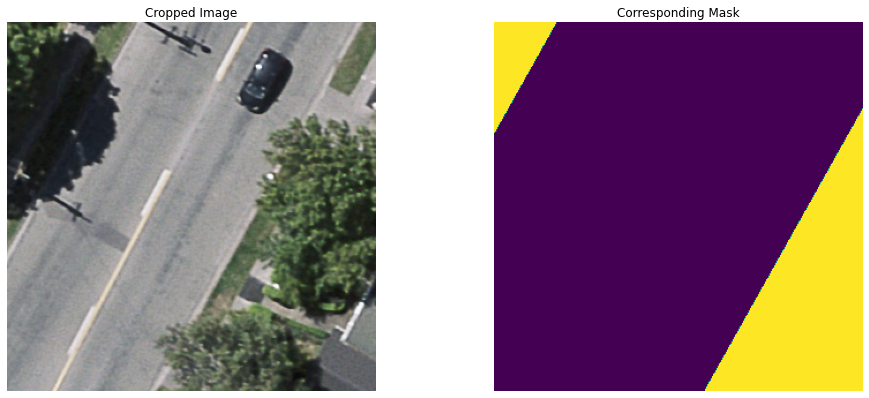

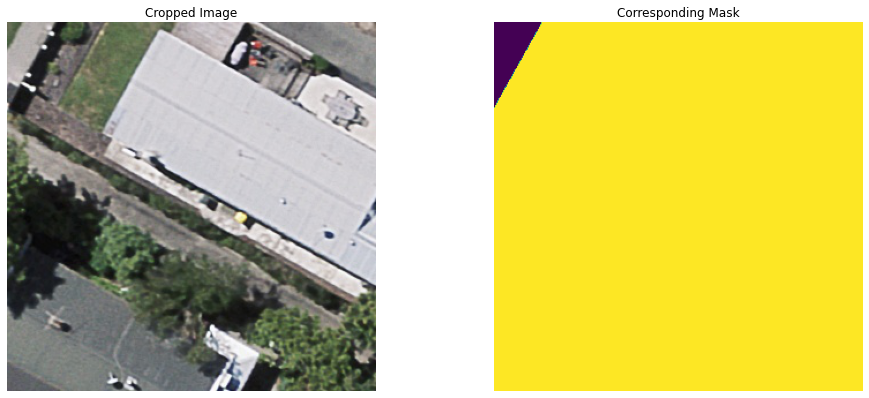

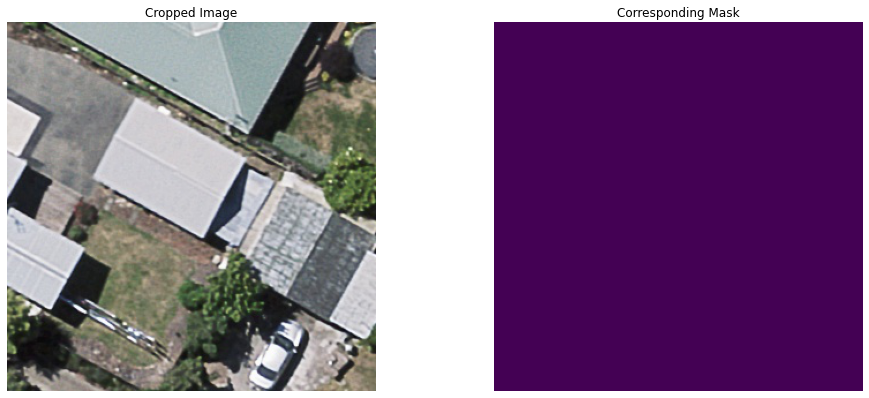

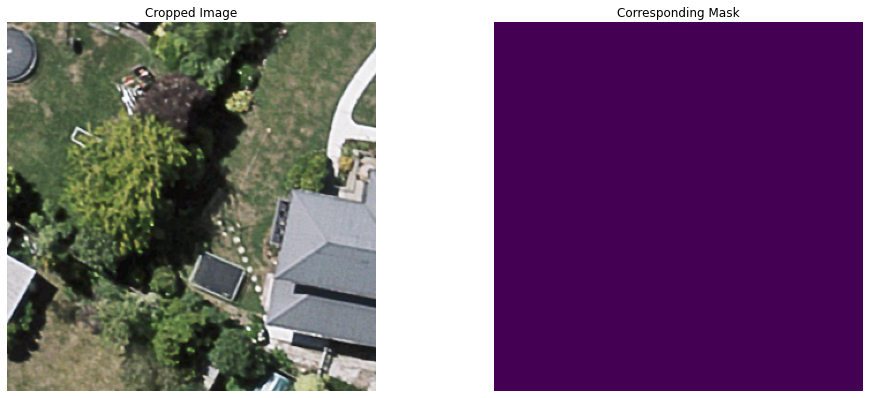

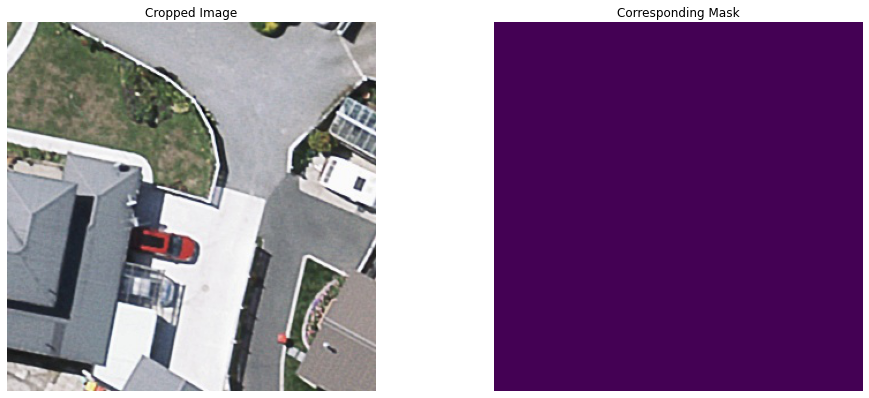

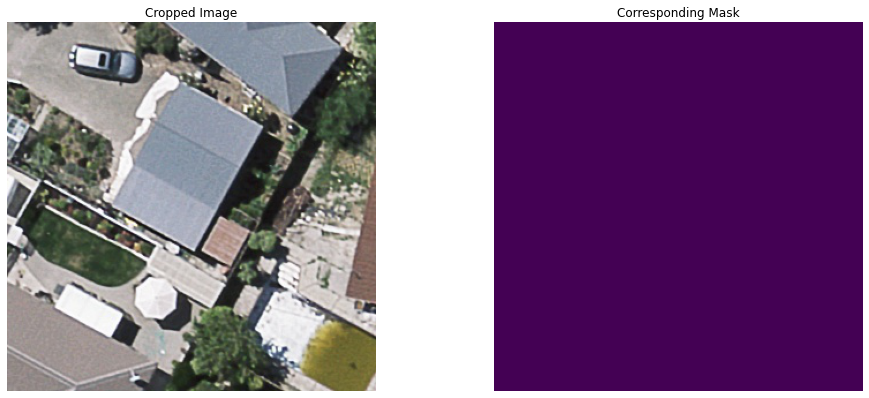

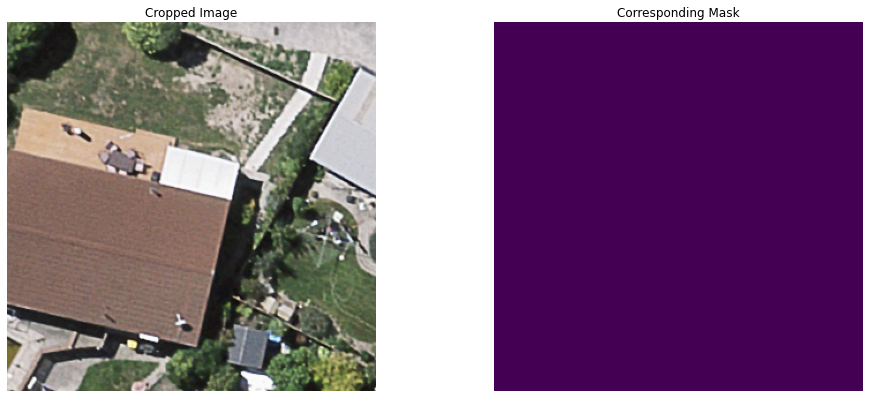

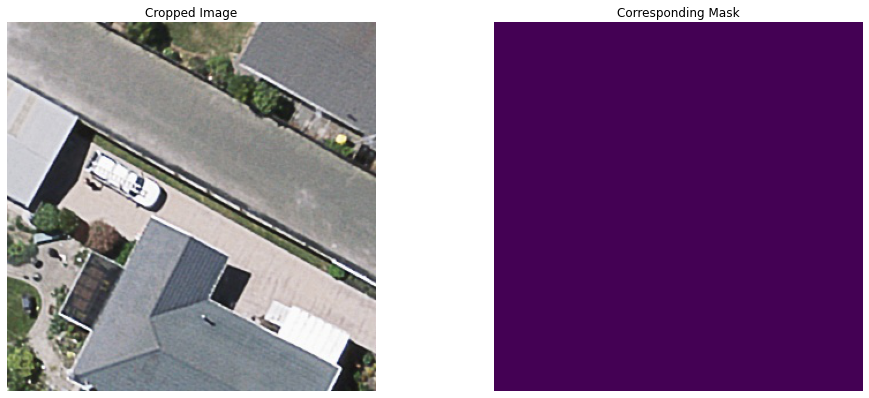

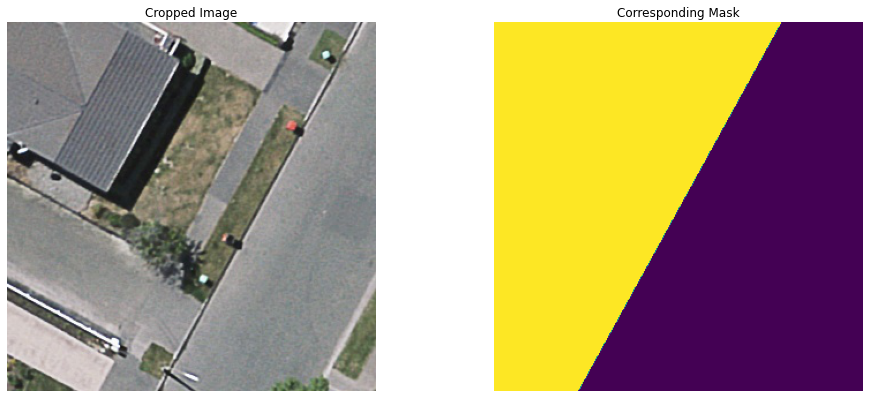

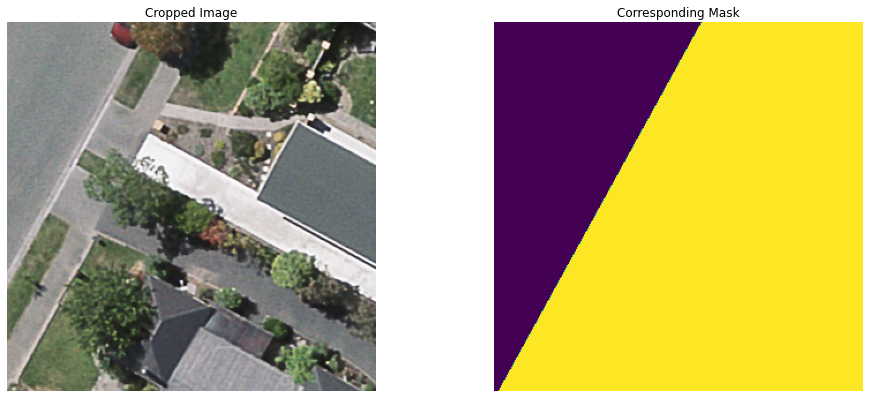

In [11]:
#Visualise the cropped images
for i in range(10):
    plt.figure(figsize=(16,80))
    plt.subplot(10,2,1+i*2)
    plt.imshow(x_train_new[i])
    plt.title("Cropped Image")
    plt.axis("off")
    
    plt.subplot(10,2,2+i*2)
    plt.imshow(y_train_new[i])
    plt.title("Corresponding Mask")
    plt.axis("off")


In [12]:
#Check the consistency of the mask pixel values in different images (above)
# 0 -> the road label (what we want)
# 1 -> other
print(np.unique(y_train_new[0], return_counts=True))
print(np.unique(y_train_new[1], return_counts=True))
print(np.unique(y_train_new[2], return_counts=True))
print(np.unique(y_train_new[3], return_counts=True))
print(np.unique(y_train_new[4], return_counts=True))
print(np.unique(y_train_new[5], return_counts=True))
print(np.unique(y_train_new[6], return_counts=True))

(array([0, 1], dtype=uint8), array([82834, 19566], dtype=int64))
(array([0, 1], dtype=uint8), array([  1553, 100847], dtype=int64))
(array([1], dtype=uint8), array([102400], dtype=int64))
(array([1], dtype=uint8), array([102400], dtype=int64))
(array([1], dtype=uint8), array([102400], dtype=int64))
(array([1], dtype=uint8), array([102400], dtype=int64))
(array([1], dtype=uint8), array([102400], dtype=int64))


- **Data augmentation**
    - The number of training images is relative small, so a data augmentation strategy could be used to **generate more training samples.** Moreover, this strategy could **increase the diversity of the training set** to help the machine learning model derive more hidden patterns.
    - The masks that contains class 0 (road segments) are what is informative but not so many in the training samples. Hence, the augmentation strategy is applied on this type of training samples (both images and the corresponding masks).

In [14]:
#Define the data augmentation strategy for the training images
def Augmentation(image, mask, seed):
    #Define a sequence of turn_on_and_offs to determine whether to use each agumentaiton strategy
    #1-> use the current augmentation method
    #0 -> not use it
    np.random.seed(seed=seed)
    
    #Define the switches for the augmentation strategies except for rotation
    turn_on_and_offs = [random.randint(0, 1) for _ in range(5)]
    
    
#     with tf.device("CPU:0"): #Perform the augmentation using cpu to avoid gpu memory leak
    #1.Rotate
    #Define the rotation degree range
    degree = [6, 4, 3, 2, 3/2, 4/3, 6/5, 1, 6/7, 4/5, 3/4, 2/3, 3/5, 4/7, 6/11]
    degree = tf.constant(np.pi/degree[np.random.randint(0, len(degree))])
    image = tfa.image.rotate(image , degree)

    mask = tfa.image.rotate(mask, degree)
    

    #2.Flip left right
    if turn_on_and_offs[0] == 1:
        image = tf.image.flip_left_right(image)

        #The Flip strategy should also be applied to the mask
        mask = tf.image.flip_left_right(mask)
    else: pass

    #3.Flip up down
    if turn_on_and_offs[1] == 1:
        image = tf.image.flip_up_down(image)

        mask = tf.image.flip_up_down(mask)
    else: pass
    
    
    #4. Change the saturation
    if turn_on_and_offs[2] == 1:
        saturation_factor = random.random() #Range from 0 to 1(exclusive)
        image = tf.image.adjust_saturation(image ,saturation_factor)
    else: pass

    #5.Change the image brightness
    if turn_on_and_offs[3] == 1:
        bright_level = np.random.uniform(low=-0.8, high=0.7) #Range from -0.8 to 0.7
        image = tf.image.adjust_brightness(image , bright_level)
    else: pass

    #6.Change the contrast
    if turn_on_and_offs[4] == 1:
        contrast_factor = random.random()+0.1  #This value should above 0 to main the visibility (0.1 to 1)
        image = tf.image.adjust_contrast(image , contrast_factor)
    else: pass
    
    return image, mask

In [15]:
#Some masks contain class 0 while other do not
#Get the index of the training masks with value 0
def Get_mask_index_with_class_0(y):
    indices_mask_with_class_zero = []

    for idx in range(y.shape[0]):
        #If a mask is filled with all 1, its summation will be 480*320
        #Otherwise, there is 0 in it
        if np.sum(y[idx])!=desired_height*desired_width:
            indices_mask_with_class_zero.append(idx)
            
    return indices_mask_with_class_zero

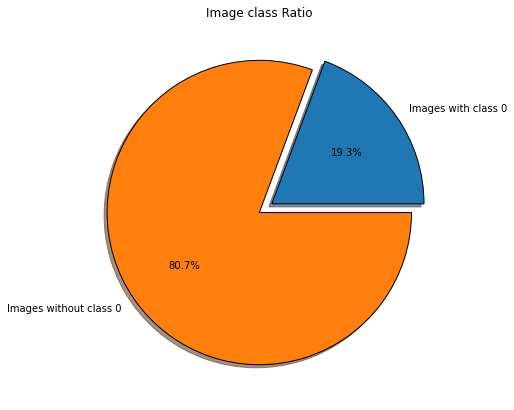

In [20]:
#Check the image imbalance
#The images with class 0 are much more than the ones without
indices = Get_mask_index_with_class_0(y_train_new)

num_images_with_class0 = len(indices)
num_images_without_class0 = 1500 - num_images_with_class0

plt.figure(figsize=(10,7))
plt.pie(x=[num_images_with_class0, num_images_without_class0], 
        labels=["Images with class 0", "Images without class 0"],
       explode=[0.1, 0],
       shadow=True, autopct="%1.1f%%",
       wedgeprops={"edgecolor":"black"})
plt.title("Image class Ratio")
plt.show()

In [16]:
#Apply augmentation strategy on the pairs of image and mask with the mask containing class 0
print("There are {}/ out of {} masks containing class 0 in training set".format(len(indices), y_train_new.shape[0]))

#Generate a seed for seting up one-to-one relation" between an image/mask and an augmentation strategy
counter = iter(tf.data.experimental.Counter())

for _ in tqdm(range(10)):
    for index in tqdm(indices):
        image_aug, mask_aug = Augmentation(image=x_train_new[index], mask=y_train_new[index], seed=next(counter))

        #Append the augmented images and masks to the training set
#         with tf.device("CPU:0"): 
        x_train_new = np.concatenate([x_train_new, image_aug[tf.newaxis,...]], axis=0)
        y_train_new = np.concatenate([y_train_new, mask_aug[tf.newaxis,...]], axis=0)
#             assert x_train_new.device.endswith("CPU:0")

x_train_new.shape, y_train_new.shape

  0%|          | 0/290 [00:00<?, ?it/s]

There are 290/ out of 1500 masks containing class 0 in training set



 54%|█████▍    | 156/290 [01:06<01:01,  2.17it/s]


  7%|▋         | 19/290 [00:09<02:08,  2.11it/s]


 60%|██████    | 175/290 [01:29<00:58,  1.96it/s]


 13%|█▎        | 38/290 [00:21<02:24,  1.74it/s]


 67%|██████▋   | 193/290 [01:54<00:59,  1.63it/s]


 20%|█▉        | 57/290 [00:37<02:39,  1.47it/s]


 73%|███████▎  | 212/290 [02:22<00:55,  1.41it/s]


 26%|██▌       | 76/290 [00:55<02:39,  1.34it/s]


 80%|███████▉  | 231/290 [02:53<00:47,  1.24it/s]


 33%|███▎      | 95/290 [01:16<02:41,  1.20it/s]


 86%|████████▌ | 249/290 [03:26<00:32,  1.25it/s]


 39%|███▉      | 113/290 [01:40<02:38,  1.12it/s]


 92%|█████████▏| 267/290 [04:03<00:23,  1.00s/it]


 45%|████▌     | 131/290 [02:07<02:30,  1.06it/s]


 98%|█████████▊| 285/290 [04:41<00:05,  1.02s/it]


 51%|█████▏    | 149/290 [02:36<02:29,  1.06s/it]


  4%|▍         | 12/290 [00:13<05:01,  1.08s/it]


 58%|█████▊    | 168/290 [03:09<02:25,  1.19s/it]


100%|██████████| 10/10 [38:31<00:00, 231.14s/it]


((4400, 320, 320, 3), (4400, 320, 320, 1))

- **Visualise augmented data**

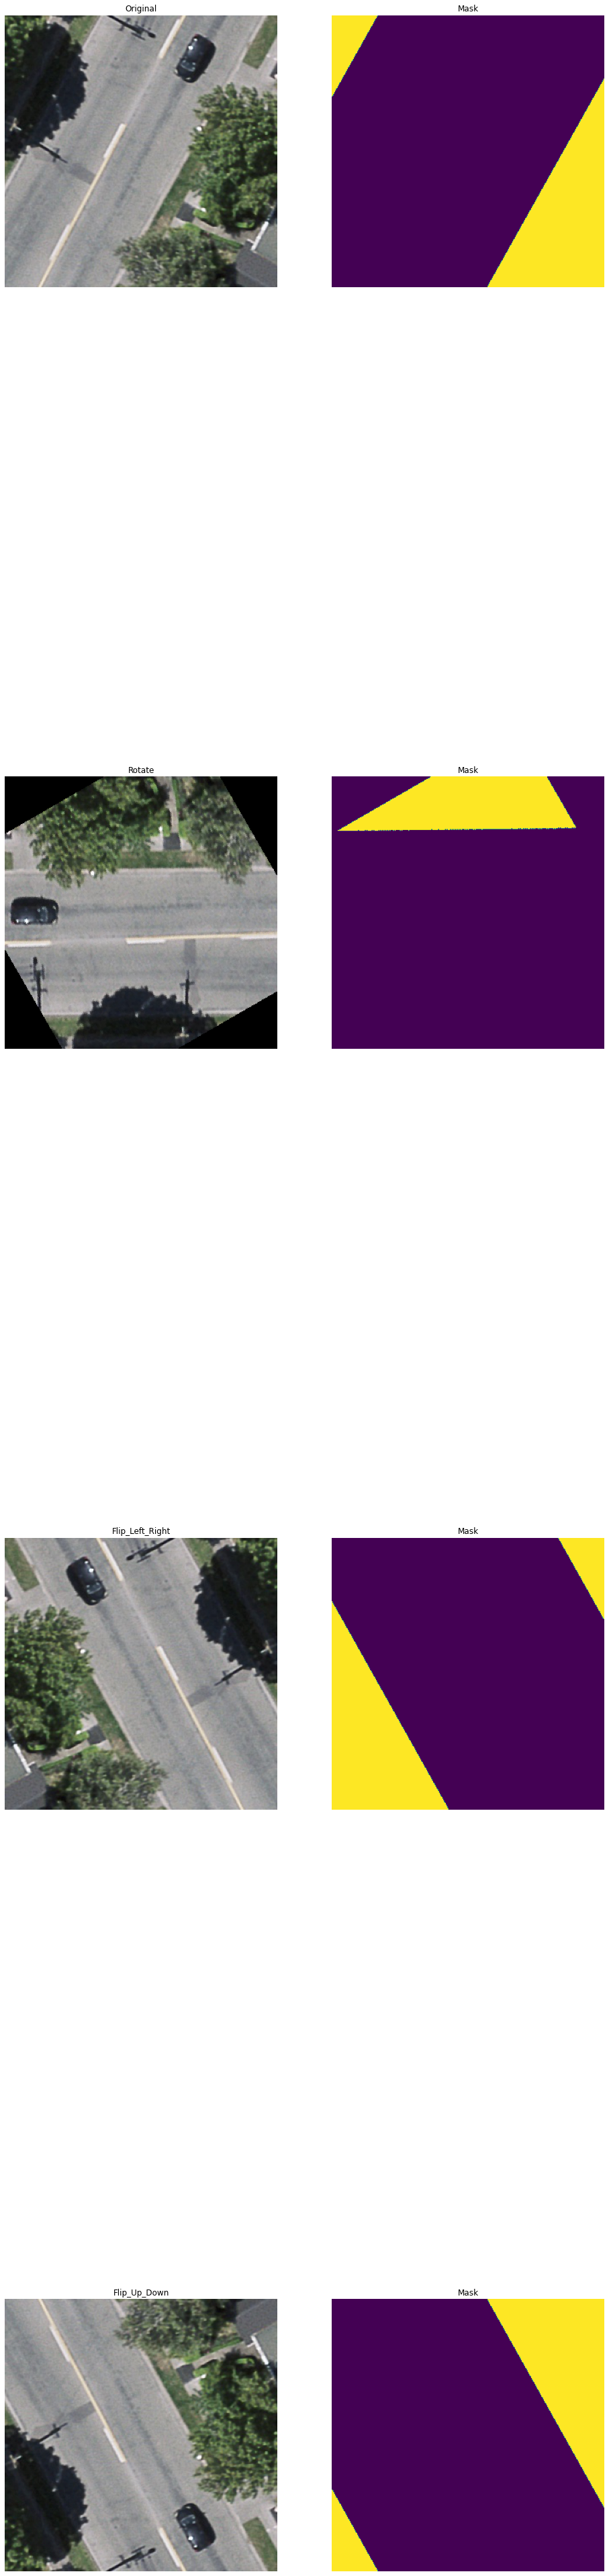

In [21]:
image_demo = x_train_new[0]
mask_demo = y_train_new[0]

#Visualise the augmented data
plt.figure(figsize=(16,80))

def Augmentation_Visualisation(i):
    titles = ["Original", "Rotate", "Flip_Left_Right", "Flip_Up_Down"]
    images = [image_demo, tfa.image.rotate(image_demo , 2*np.pi/3), tf.image.flip_left_right(image_demo),
             tf.image.flip_up_down(image_demo)]
    
    masks = [mask_demo, tfa.image.rotate(mask_demo , 2*np.pi/3), tf.image.flip_left_right(mask_demo),
             tf.image.flip_up_down(mask_demo)]
    
    
    plt.subplot(4,2,1+i*2)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.axis("off")
    
    plt.subplot(4,2,2+i*2)
    plt.title("Mask")
    plt.imshow(masks[i])
    plt.axis("off")


for i in range(4):
    Augmentation_Visualisation(i)

In [22]:
#Brightness, Contrast, and Saturation can influence the visibility of the images even by human eyes
#So, visualising their key factor ranges to manually define the augmentation ranges is important
#Visualise and discover the value range of some augmentation methods
import ipywidgets as widgets

def Adjust_brightness_show(b):
    plt.figure(figsize=(8,10))
    plt.title("Brightness")
    plt.imshow(tf.image.adjust_brightness(x_train_new[0], b))
    plt.axis("off")

def Adjust_contrast_show(c):
    plt.figure(figsize=(8,10))
    plt.title("Contrast")
    plt.imshow(tf.image.adjust_contrast(x_train_new[0], c))
    plt.axis("off")

def Adjust_saturation_show(s):
    plt.figure(figsize=(8,10))
    plt.title("Saturation")
    plt.imshow(tf.image.adjust_saturation(x_train_new[0], s))
    plt.axis("off")

    
widgets.interact(Adjust_brightness_show, b=(-1,1, 0.1))
widgets.interact(Adjust_contrast_show, c=(0,1, 0.1))
widgets.interact(Adjust_saturation_show, s=(0,1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='b', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

interactive(children=(FloatSlider(value=0.0, description='c', max=1.0), Output()), _dom_classes=('widget-inter…

interactive(children=(FloatSlider(value=0.0, description='s', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.Adjust_saturation_show(s)>

- **Build data piplines**

In [23]:
#Define an input data function
def input_fn_train(x_train, y_train, batch_size):
    AUTOTUNE = tf.data.AUTOTUNE
        
    #Build up data pipeline
    db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).prefetch(AUTOTUNE)

    return db_train

In [25]:
batch_size = 32

db_train = input_fn_train(x_train_new, y_train_new, batch_size)

iterator_train = iter(db_train)

In [26]:
cc = next(iterator_train)
cc[0].shape, cc[1].shape

(TensorShape([32, 320, 320, 3]), TensorShape([32, 320, 320, 1]))

## <span style="color:blue">Model Development</span>

### <span style="color:darkblue">Select the base model for transfer learning</span>

In [70]:
#Select VGG19 as the base model for transfer learning
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=[desired_height, desired_width, 3], 
                                                        include_top=False, 
                                                        weights='imagenet', 
                                                        pooling=None)

In [71]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 326, 326, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

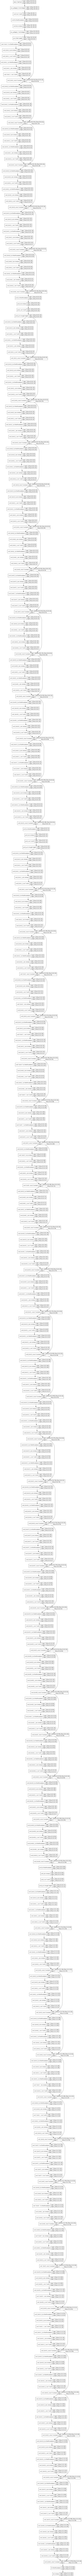

In [72]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [73]:
#Get all the pooling layer names according to the model summary
#Get all the pooling layer names according to the model summary
layer_names = [
    "conv1/relu",    #160*160
    "pool2_relu",    #80*80
    "pool3_relu",    #40*40
    "pool4_relu",   #20*20
    "relu",          #10*10
]

In [74]:
#Get the outputs from each pooling layer
output_layers = [base_model.get_layer(name).output for name in layer_names]

#Build up the encoder
encoder = tf.keras.Model(inputs=base_model.input, outputs=output_layers)

encoder.trainable=False

In [75]:
#Decoder
decoder = [
    pix2pix.upsample(512, 3),    #10*10 -> 20*20
    pix2pix.upsample(256, 3),    #20*20 -> 40*40
    pix2pix.upsample(128, 3),    #40*40 -> 80*80
    pix2pix.upsample(64, 3)      #80*80 -> 160*160
]

### <span style="color:darkblue">Model construction</span>

In [76]:
#Construct the model
def Unet(num_output_channels=2):
    inputs = tf.keras.layers.Input(shape=[desired_height, desired_width, 3])
    x = inputs

    #Capture the image patterns by encoder
    skips = encoder(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    #Rebuild the image by decoder
    #Locate the image pixels by skipping strategy
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    #Up-sampling the image by transposed convolution layer
    TransposedConv = tf.keras.layers.Conv2DTranspose(
        num_output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    output = TransposedConv(x)

    return tf.keras.Model(inputs=inputs, outputs=output)

### <span style="color:darkblue">Loss function determination</span>
<span style="color:red"> Address the imbalance learning using crossentropy loss with class weight strategy.</span>\
General concepts behind. Take a linear calculation as example (Similarly, the convolution computation can be seen as multiple linear calculation taken in parallel and especially for many times in deep learning model):
!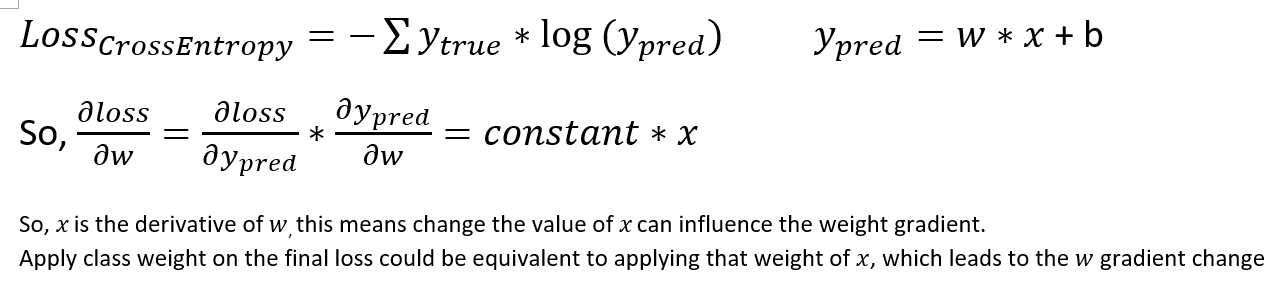
<span style="color:red">**The gradient change can make the model pay more/ less attention to the weights associated with the images pixels of different classes.**</span>

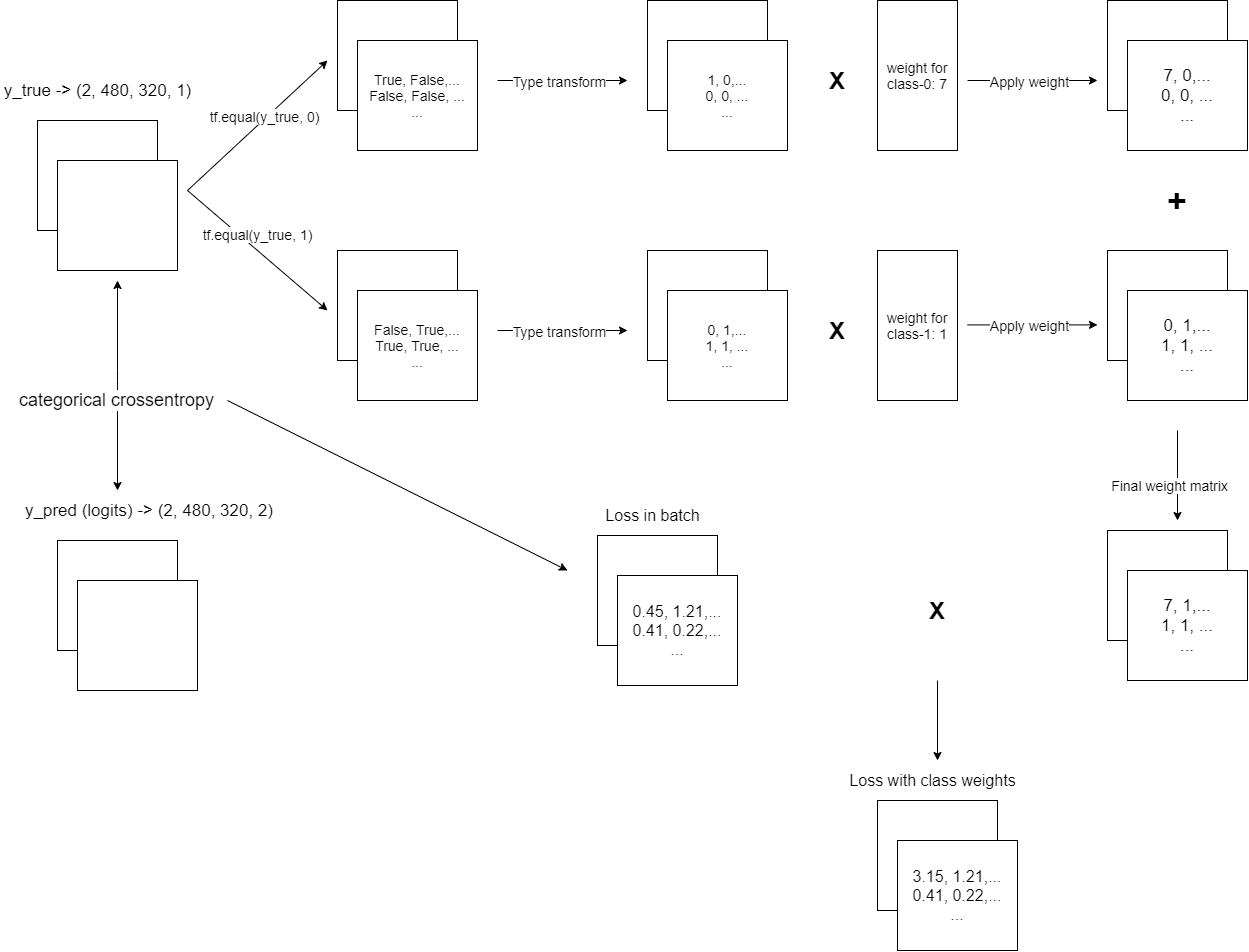

In [77]:
#Get the proportion of the majority class over the minority class in pixel-level
class_proportion = np.unique(y_train_new, return_counts=True)
class_proportion = class_proportion[1][1] / class_proportion[1][0]

#Set the class weights inverse to the class proportion
list_class_weights = [class_proportion, 1.]
list_class_weights

[1.866740464109731, 1.0]

In [78]:
def Loss_fn_weighted(y_true, y_pred):
    #y_true -> default dytpe: uint8
    #list_class_weights -> default dtype: float32

    #Get the pix-level class distribution on the truth sample
    y_true_class = tf.squeeze(y_true, axis=-1)
    y_true_class = tf.cast(y_true_class, tf.int32)

    #Identify the class distribution
    class_comparisons_boolean = [tf.equal(i, y_true_class) for i in range(len(list_class_weights))]
    class_comparisons_float = [tf.cast(class_comparison, tf.float32) for class_comparison in class_comparisons_boolean]

    #Apply the class weights onto the class comparisons element-wisely
    class_weights_distribution = [ccf * cw for ccf,cw in zip(class_comparisons_float, list_class_weights)] 

    #Sum the class weights to get the final weight multipiler
    weight_multiplier = class_weights_distribution[0]
    for i in range(1, len(class_weights_distribution)):
        weight_multiplier = weight_multiplier + class_weights_distribution[i]


    #Apply the final weight multipiler onto the original loss
        #CategoricalCrossentropy only accepts (half, bfloat16, float, double) types
    y_true_onehot = tf.one_hot(y_true_class, depth=2, axis=-1)
    
    loss = tf.losses.categorical_crossentropy(y_true_onehot, y_pred, from_logits=True)
    
    loss = loss * weight_multiplier

    return tf.reduce_mean(loss)

### <span style="color:darkblue">Evaluation metrics determination</span>
- **This project aims at detecting the road segments, but both the positive cases (road segments) and the negative cases (non-road stuff) should be classified correctly.** If misclassify the postive cases into the negative cases, it fails to detect the road segments. On the other hand, if misclassify the negative cases into positive cases, there could some potential dangers in practice, such as traffic accidents will occur when applying this project in drawing maps for auto-driving.
- **Traditional accuracy metric can reflect the model's overall performance in identifying the positive and negative cases, but it cannot address the data imbalance issue.** The road segment detection is normally related to an imbalanced data, since non-road stuff is much more than road segments. Correctly classifying most of the negative cases can result in a high accuracy, despite the model misclassifying most of the positive cases. **Therefore, a transformed accuracy metric should be used to avoid this issue. The unweighted accuracy or average recognition rate is right one in this case.** It refects the average between the recall of the positive cases and the recall of the negative cases (or it's called specificity in this binary classification project).\
- **Recall and Specificity are also used as the respective metric for reflecting the model's performance in identifying the postive cases and negative cases.**

In [79]:
#Define custom metrics
#AUC, Recall, and Specificity
#For the stability of numeric caluation below, a small number is used in division operation 
epsilon = 1e-7

def Average_Recognition_Rate(y_true, y_pred):
    #(None, 480, 320, 2) -> (None, 480, 320)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    #(None, 480, 320, 1) -> (None, 480, 320)
    y_true = tf.squeeze(y_true, axis=-1)
    
    #class 0 for road segments --- Postive case
    #class 1 for other stuff --- Negative case
    
    #For recall
    #Identify the TP by summation and comparison
        #TP: 0+0=0
        #FP/ FN: 1+0=0+1=1
        #TN: 1+1=2
    TP = tf.cast(tf.equal(y_pred+y_true, 0.0), tf.float32)
    #Get the TP image-wisely (only height and width channel)
    TP = tf.reduce_sum(TP, axis=(1,2))
    
    #Get all the Positive cases image-wisely
    P = tf.cast(tf.equal(y_true, 0.0), tf.float32)
    P = tf.reduce_sum(P, axis=(1,2))
    
    recall = TP/(P+epsilon)
    
    
    #For specificity
    #Identify the TN by summation and comparison
    TN = tf.cast(tf.equal(y_pred+y_true, 2.0), tf.float32)
    #Get the TN image-wisely (only height and width channel)
    TN = tf.reduce_sum(TN, axis=(1,2))
    
    #Get all the Negative cases image-wisely
    N = tf.cast(tf.equal(y_true, 1.0), tf.float32)
    N = tf.reduce_sum(N, axis=(1,2))
    
    specificity = TN/(N+epsilon)
    
    #For Average_Recognition_Rate
    #Recall could be seemed as the recognition rate for class 0
    #Specifity could be seemed as the recognition rate for class 1
    Average_Recognition_Rate = (recall+specificity)/2
    
    return tf.reduce_mean(Average_Recognition_Rate)


def Recall(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.squeeze(y_true, axis=-1)
    
    epsilon = 1e-7

    TP = tf.cast(tf.equal(y_pred+y_true, 0.0), tf.float32)
    TP = tf.reduce_sum(TP, axis=(1,2))
    
    P = tf.cast(tf.equal(y_true, 0.0), tf.float32)
    P = tf.reduce_sum(P, axis=(1,2))
    
    recall = TP/(P+epsilon)
    
    return tf.reduce_mean(recall)


def Specificity(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.squeeze(y_true, axis=-1)
    
    TN = tf.cast(tf.equal(y_pred+y_true, 2.0), tf.float32)
    TN = tf.reduce_sum(TN, axis=(1,2))
    
    N = tf.cast(tf.equal(y_true, 1.0), tf.float32)
    N = tf.reduce_sum(N, axis=(1,2))
    
    specificity = TN/(N+epsilon)
    
    return tf.reduce_mean(specificity)

In [80]:
#Learning rate scheduler
lr = 1e-1
decay = 1e-6
num_epochs_for_LrDecrease = 2

#Set a learning rate decay of 
def lr_scheduler(epoch):
    return lr * (0.5 ** (epoch // num_epochs_for_LrDecrease))

#Wrap the scheduler into a callback
lr_decrease = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [81]:
#The num_output_channels is set to 2
#Because there only 2 possible values -- 0 and 1 in the mask
model = Unet(num_output_channels=2)


#Set up the optimizer and compile and model
lr = 1e-1
optimiser = tf.keras.optimizers.SGD(learning_rate=lr, decay=decay, momentum=0.9, nesterov=True)

model.compile(optimizer=optimiser,
              loss=Loss_fn_weighted,
              metrics=["acc", Average_Recognition_Rate, Recall, Specificity])

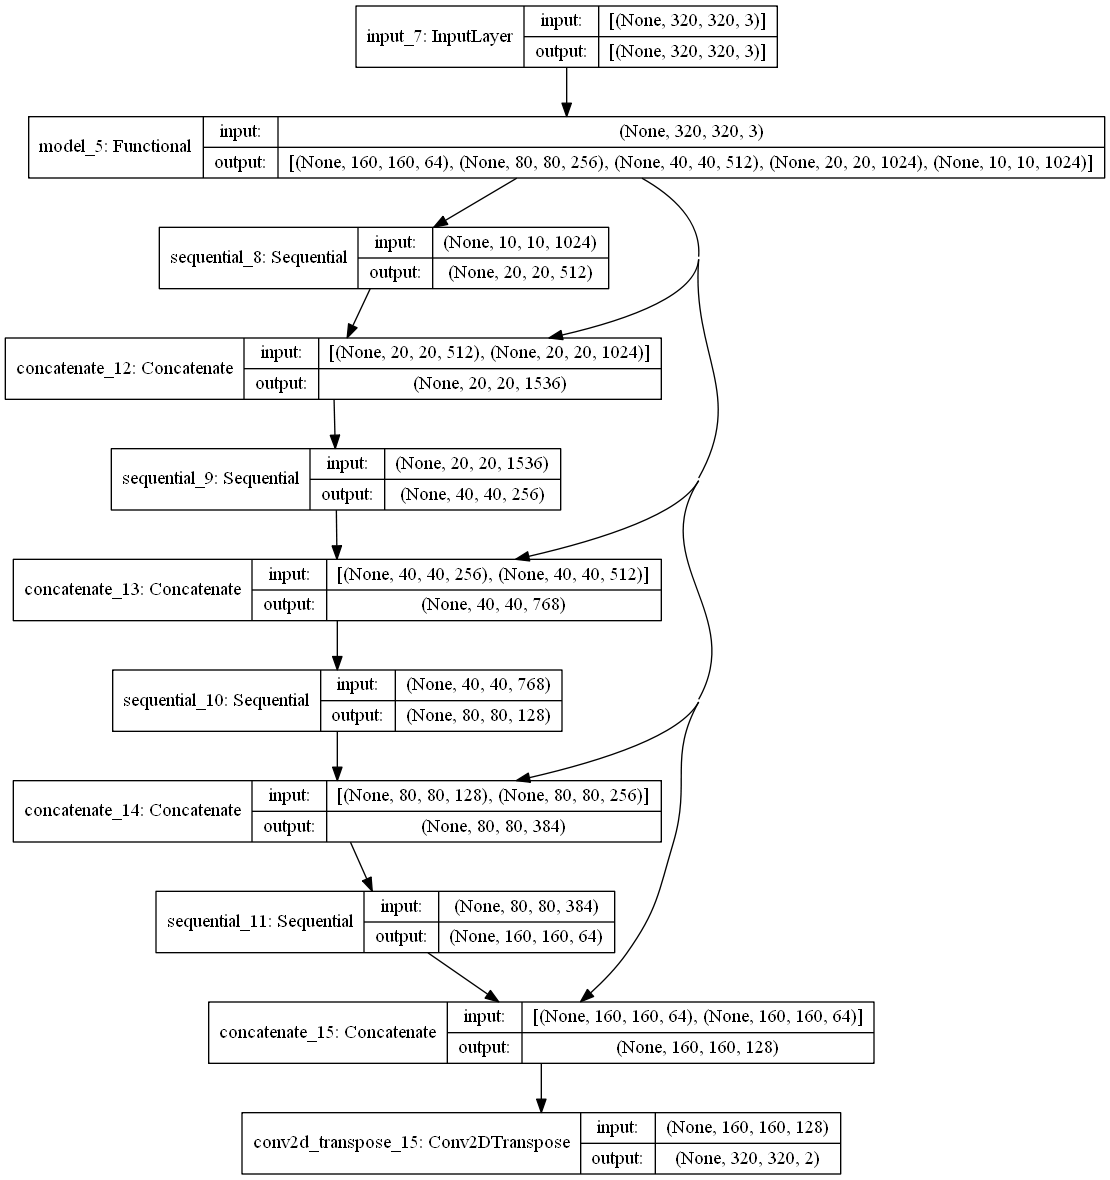

In [82]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [83]:
#The function for converting the logits output from the model into an image mask
def Convert_to_Mask(output):
    #Channel dimension comparison to derive the channel label of each pixel in the final mask
    mask = tf.argmax(output, axis=-1)
    #Add the channel dimension
    mask = mask[..., tf.newaxis]
    return mask
    
#For display the image, true mask, and predicted mask
def Display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


def Display_predictions():
    output = model(x_train_new[87][tf.newaxis,...])
    Display([x_train_new[87], y_train_new[87], Convert_to_Mask(tf.squeeze(output, axis=0))])

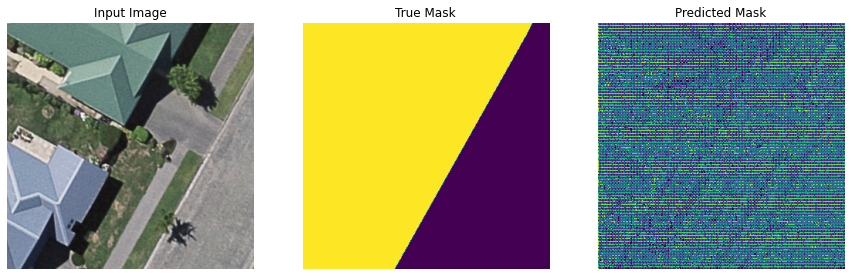

In [84]:
Display_predictions()

In [85]:
#Create a callback to display the predicted mask after each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #For showing predicted mask
        clear_output(wait=True)
        Display_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
#Create a callback for tensorboard
callback_tb = tf.keras.callbacks.TensorBoard(
    log_dir = "D:\\Programming\\Python\\Tensorflow\\Logs\\Road_Segments\\", histogram_freq = 1
)

#Create a callback for early stopping
callback_earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", min_delta=0.05,
    patience=5, mode="min",
    restore_best_weights=True
)

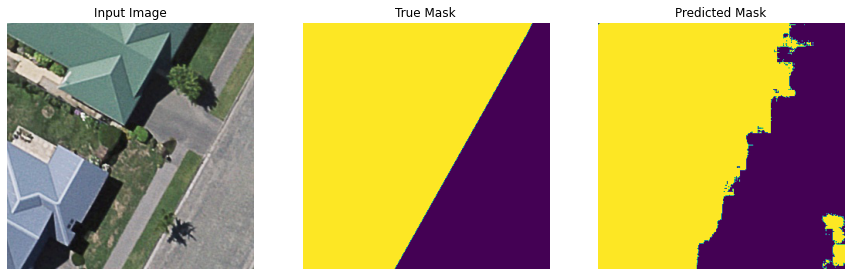


Sample Prediction after epoch 19



In [86]:
EPOCHS = 100

model_history = model.fit(db_train, epochs=EPOCHS,
                          callbacks=[lr_decrease, DisplayCallback(), callback_tb, callback_earlyStopping],
                          initial_epoch=0,
                          workers=-1, use_multiprocessing=True)

## <span style="color:blue">Make predictions for testing images</span>

### <span style="color:darkblue">Read testing images</span>

In [87]:
#Since some testing images have different shapes, so reading them one by one can avoid error
#Reading one image and splitting it into the desired height and width size
#Making prediction on the splitted images and then reconstructing the predictions to form a final mask
def Read_Predict_Reconstruct(path_img, model):
    #1.Read the images
    for _,_,img_files in os.walk(path_img):
        for img_file in tqdm(img_files):
            if img_file.split(".")[-1] == "jpg":  #only get the image files
                path_image = path_img + img_file
                image = plt.imread(path_image)
                
                #scale the image
                image = image/255.0
                
                img_height, img_width = image.shape[0], image.shape[1]
                #2.Crop the image into desired height and width

                num_height_splits = int(img_height/desired_height)
                rest_height_split = img_height%desired_height
                
                num_width_splits = int(img_width/desired_width)
                rest_width_split = img_width%desired_width        
                
                #Padding the rest image height
                if rest_height_split != 0:
                    padding_height = desired_height - rest_height_split
                    num_height_splits += 1

                    #Doing height padding for the whole image
                    image = np.concatenate((image, np.zeros((padding_height, img_width, 3))), axis=0)
                
                #Padding the rest image width
                if rest_width_split != 0:
                    padding_width = desired_width - rest_width_split
                    width_padding_area = np.zeros(shape=(image.shape[0], padding_width, 3))
                    
                    image = np.concatenate((image, width_padding_area), axis=1)
                    
                    num_width_splits += 1
                
                
                #Iterate over the whole image and split it
                masks_predicted = []
                for i in tqdm(range(num_height_splits)):
                    for j in range(num_width_splits):
                        img = image[i*desired_height:(i+1)*desired_height, j*desired_width:(j+1)*desired_width, :]
                        
                        
                        #3. Make predictions on the image split using the model
                        mask_predicted = model(img[np.newaxis,...])
                        mask_predicted = tf.argmax(mask_predicted, axis=-1)[..., tf.newaxis]
                        masks_predicted.append(np.squeeze(mask_predicted, axis=0))
                
                print("There are {0} sub_masks for this image, and one of them has the shape {1}".format(len(masks_predicted),
                                                                                                         masks_predicted[0].shape))
                
                
                #4. Unite predicted masks
                #Reconstruct the image row
                rows = []
                for row_id in range(num_height_splits):
                    #The first image in each row
                    first_img_per_row = masks_predicted[row_id*num_width_splits]
                    
                    for width_split_id in range(num_width_splits-1):
                        first_img_per_row = np.concatenate((first_img_per_row, masks_predicted[num_width_splits*row_id + width_split_id+1]), axis=1)

                    rows.append(first_img_per_row)


                #Reconstruct the image height
                mask = rows[0]
                for t in range(1, len(rows)):
                    mask = np.concatenate((mask, rows[t]), axis=0)
                
                #Crop out the padded area
                mask = mask[:img_height, :img_width, :]
                print("The shape of the whole is, ", mask.shape)
                    

                #5.Save the mask
                cv2.imwrite("D:/"+img_file+".mask.tif", mask)

In [88]:
Read_Predict_Reconstruct(path_test_images, model)

100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


There are 324 sub_masks for this image, and one of them has the shape (320, 320, 1)


  5%|▌         | 2/38 [00:24<07:12, 12.01s/it]

The shape of the whole is,  (5710, 5749, 1)



100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


There are 126 sub_masks for this image, and one of them has the shape (320, 320, 1)


 16%|█▌        | 6/38 [00:33<02:34,  4.83s/it]

The shape of the whole is,  (2079, 5749, 1)



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


 26%|██▋       | 10/38 [00:44<01:45,  3.76s/it]

The shape of the whole is,  (4800, 3200, 1)



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


 39%|███▉      | 15/38 [00:55<01:09,  3.01s/it]

The shape of the whole is,  (4800, 3200, 1)



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


 53%|█████▎    | 20/38 [01:06<00:48,  2.67s/it]

The shape of the whole is,  (4800, 3200, 1)



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


 66%|██████▌   | 25/38 [01:17<00:32,  2.50s/it]

The shape of the whole is,  (4800, 3200, 1)



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


 74%|███████▎  | 28/38 [01:28<00:27,  2.77s/it]

The shape of the whole is,  (4800, 3200, 1)



100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


There are 150 sub_masks for this image, and one of them has the shape (320, 320, 1)


100%|██████████| 38/38 [01:39<00:00,  2.61s/it]

The shape of the whole is,  (4800, 3200, 1)


# Limitations
- Limited training samples
- Weight list for the loss is not so strict.\
It is simply the reversed proportion of the majority over the minority class; However, the convolution weight gradients in the deep model  will be more complicated.
- Due to computational restriction, not so much augmented training samples are generated.
